In [1]:
from randomDistricts import Hierarchy_2D
from treelib import Node, Tree
import pickle
from functools import partial
import pandas as pd
import seaborn as sns

import random
a = random.randint(0,10000000000)
import networkx as nx
from gerrychain.random import random
random.seed(a)
from gerrychain import (Graph, Partition, MarkovChain, tree,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
import matplotlib.pyplot as plt
import matplotlib
import operator
import functools
import numpy as np
from math import sqrt, floor
import math
import os
import csv
import json
import geopandas as gpd

In [2]:
foldr = lambda func, acc, xs: functools.reduce(lambda x, y: func(y, x), xs[::-1], acc)

In [3]:
with open("data/dallas_hierarcy.p", "rb") as fout:
    h = pickle.load(fout)

In [4]:
G = h.graph

In [5]:
rand_colors = ['blue', 'orange', 'green', 'red', 'yellow','indigo', 'darkorange', 'yellowgreen', 'saddlebrown', 'pink', 'dimgray', 'cornflowerblue', 'cyan', 'gainsboro']

def draw_graph(G, num_districts, pos_map, plan_assignment):
    col_map = {v:plan_assignment[v] if v in plan_assignment.keys() else num_districts for v in G.nodes()}

    plt.figure()
    nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 50, width = 2, node_color=[col_map[v] for v in G.nodes()], cmap = matplotlib.colors.ListedColormap(rand_colors))
    plt.show()

In [35]:
num_dist = 4
ep = .05
pop_map = {v:G.nodes[v]['TOTPOP10'] for v in G.nodes()}
pos_map = {v:(float(G.nodes[v]['INTPTLON10']),float(G.nodes[v]['INTPTLAT10'])) for v in G.nodes()}
maxlon = max(pos_map[v][0] for v in G.nodes())
minlon = min(pos_map[v][0] for v in G.nodes())
lon_diff = maxlon-minlon
maxlat = max(pos_map[v][1] for v in G.nodes())
minlat = min(pos_map[v][1] for v in G.nodes())
lat_diff = maxlat-minlat

bounding_box_ep = 0.2

bounding_box_dict = {v:[pos_map[v][0] + bounding_box_ep*lon_diff,
                        pos_map[v][0]+ bounding_box_ep*lon_diff, 
                        pos_map[v][1]+ bounding_box_ep*lat_diff,
                        pos_map[v][1]+ bounding_box_ep*lat_diff] for v in G.nodes()}  
ideal_pop = sum([pop_map[v] for v in G.nodes()])/num_dist

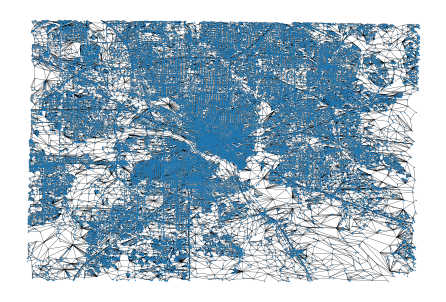

In [7]:
nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 0.1, width = 0.25,
#         node_color=[col_map[v] for v in G.nodes()],
        cmap = matplotlib.colors.ListedColormap(rand_colors))

In [8]:
def neutral_iid(G, ideal_pop, pop_map, ep):

    district_nodes = []
    processed_nodes = set()
    seed = random.choice(list(G.nodes()))
    district_nodes.append(seed)

    local_frontier = set(G.neighbors(seed))
    processed_nodes.add(seed)
    cur_dist_pop = pop_map[seed]
    
    while cur_dist_pop < ideal_pop:

        if len(local_frontier) == 0 and cur_dist_pop < (1-ep)*ideal_pop:
            return False, district_nodes
        if len(local_frontier) == 0 and cur_dist_pop >= (1-ep)*ideal_pop:
            return True, district_nodes
        
        spread = random.choice(list(local_frontier))
        if cur_dist_pop + pop_map[spread] > (1+ep)*ideal_pop:
            local_frontier.remove(spread)
        else:
            processed_nodes.add(spread)
            district_nodes.append(spread)
            cur_dist_pop += pop_map[spread]

            local_frontier = local_frontier.union(set(G.neighbors(spread))).difference(processed_nodes)
    return True, district_nodes

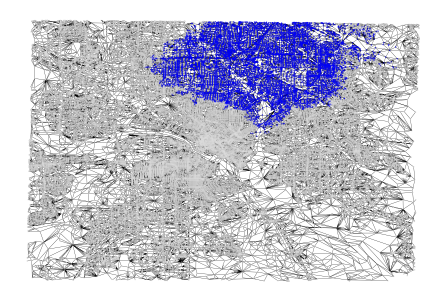

In [36]:
success, plan = neutral_iid(G, ideal_pop, pop_map, ep)
col_map = {v:0 if v in plan else 1 for v in G.nodes()}
nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 0.1, width = 0.25,
        node_color=[col_map[v] for v in G.nodes()],
        cmap = matplotlib.colors.ListedColormap(rand_colors))

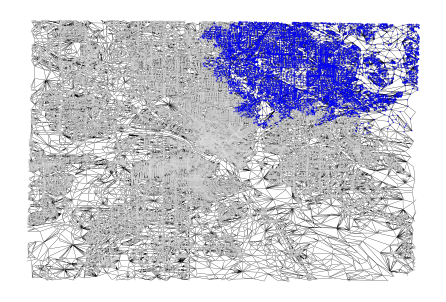

In [292]:
success, plan = neutral_iid(G, ideal_pop, pop_map, ep)
col_map = {v:0 if v in plan else 1 for v in G.nodes()}
nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 0.1, width = 0.25,
        node_color=[col_map[v] for v in G.nodes()],
        cmap = matplotlib.colors.ListedColormap(rand_colors))

(2410526.1019965364, 2585578.2323750895, 6877612.340391582, 7054307.606321895)

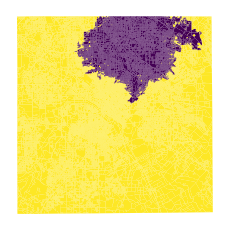

In [37]:
p = Partition(G, col_map, updaters={"cut_edges": cut_edges, "population": Tally("TOTPOP10")})
p.plot()
plt.axis('off')

In [38]:
def bounding_box_iid(G, ideal_pop, pop_map, ep, bounding_box_dict):

    district_nodes = []
    processed_nodes = set()
    seed = random.choice(list(G.nodes()))
    district_nodes.append(seed)

    local_frontier = set(G.neighbors(seed))
    processed_nodes.add(seed)
    cur_dist_pop = pop_map[seed]
    bounding_box = bounding_box_dict[seed]
    while cur_dist_pop < ideal_pop:


        if len(local_frontier) == 0 and cur_dist_pop < (1-ep)*ideal_pop:
            return False, district_nodes
        if len(local_frontier) == 0 and cur_dist_pop >= (1-ep)*ideal_pop:
            return True, district_nodes

        bounded_frontier = []
        box_x_min = bounding_box[0]
        box_x_max = bounding_box[1]
        box_y_min = bounding_box[2]
        box_y_max = bounding_box[3]

        for v in local_frontier:
            if box_x_min <= bounding_box_dict[v][0] and box_x_max >= bounding_box_dict[v][1] and box_y_min <= bounding_box_dict[v][2] and box_y_max >= bounding_box_dict[v][3]:
                bounded_frontier.append(v)

        if len(bounded_frontier) > 0:
            spread = random.choice(bounded_frontier)
        else:
            spread = random.choice(list(local_frontier))

        if cur_dist_pop + pop_map[spread] > (1+ep)*ideal_pop:
            local_frontier.remove(spread)
        else:
            bounding_box = [min(box_x_min,bounding_box_dict[spread][0]),
                                                max(box_x_max,bounding_box_dict[spread][1]),
                                                min(box_y_min,bounding_box_dict[spread][2]),
                                                max(box_y_max,bounding_box_dict[spread][3])]
            processed_nodes.add(spread)
            district_nodes.append(spread)
            cur_dist_pop += pop_map[spread]

            local_frontier = local_frontier.union(set(G.neighbors(spread))).difference(processed_nodes)
    return True, district_nodes

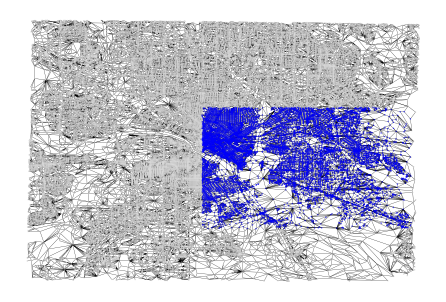

In [60]:
success, plan = bounding_box_iid(G, ideal_pop, pop_map, ep, bounding_box_dict)
col_map = {v:0 if v in plan else 1 for v in G.nodes()}
nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 0.1, width = 0.25,
        node_color=[col_map[v] for v in G.nodes()],
        cmap = matplotlib.colors.ListedColormap(rand_colors))

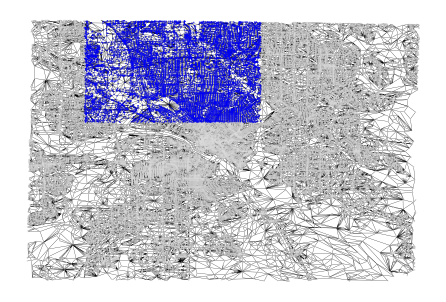

In [61]:
success, plan = bounding_box_iid(G, ideal_pop, pop_map, ep, bounding_box_dict)
col_map = {v:0 if v in plan else 1 for v in G.nodes()}
nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 0.1, width = 0.25,
        node_color=[col_map[v] for v in G.nodes()],
        cmap = matplotlib.colors.ListedColormap(rand_colors))

In [67]:
p = Partition(G, col_map, updaters={"cut_edges": cut_edges, "population": Tally("TOTPOP10")})

(2410526.1019965364, 2585578.2323750895, 6877612.340391582, 7054307.606321895)

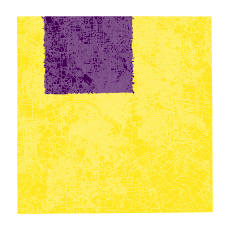

In [72]:
p.plot()
plt.axis('off')

In [69]:
p["population"]

{1: 1776059, 0: 592080}

In [205]:
h.gdf.TOTPOP10.sum()

2368139

In [94]:
h.gdf.dissolve(by=h.gdf.GEOID10.apply(lambda x: x[:-4]), aggfunc="sum")

geometry   ALAND10  \
GEOID10                                                                    
48113000100  POLYGON ((2510448.464 6981748.469, 2510413.656...   3065094   
48113000201  POLYGON ((2505133.856 6987331.796, 2505137.316...   1762502   
48113000202  POLYGON ((2500518.905 6986714.682, 2500183.511...   1571513   
48113000300  POLYGON ((2495367.223 6986841.185, 2495284.460...   1811664   
48113000401  POLYGON ((2485835.757 6977838.446, 2485801.193...   2032888   
...                                                        ...       ...   
48113020500  POLYGON ((2473290.098 6965802.706, 2473251.818...   5448152   
48113020600  POLYGON ((2484945.725 7002004.354, 2484796.469...   5263995   
48113020700  POLYGON ((2472761.935 7033626.863, 2472680.583...   6008118   
48113980000  POLYGON ((2419882.019 6990637.506, 2419751.538...  27184723   
48113980100  POLYGON ((2477788.477 6988995.640, 2477360.164...   5493431   

             AWATER10  TOTPOP10  NH_WHITE10  NH_BLACK10  NH_AMIN10  \
GEOID10                                                              
48113000100    511269      4009        3243          97         11   
48113000201         0      2875        2485          28         14   
48113000202     30513      3409        2840          47         19   
48113000300         0      4080        3346          96          9   
48113000401         0      4830         875         531          7   
...               ...       ...         ...         ...        ...   
48113020500    144063      4820         148        2789          7   
48113020600         0      2462        2199          19          3   
48113020700    189401      5022        3130         361         10   
48113980000      1289         0           0           0          0   
48113980100         0        10           1           0          0   

             NH_ASIAN10  NH_NHPI10  NH_OTHER10  ...  AMNCPOP10M  ACPOP10M  \
GEOID10                                         ...                         
48113000100          61          1           4  ...       146.0      57.0   
48113000201          67          1           5  ...       268.0     200.0   
48113000202          79          0           0  ...       190.0     328.0   
48113000300         161          3           6  ...       381.0     326.0   
48113000401         509          0          10  ...       381.0     192.0   
...                 ...        ...         ...  ...         ...       ...   
48113020500         194         10           5  ...       254.0     167.0   
48113020600          75          0           1  ...       254.0     227.0   
48113020700         248          0           7  ...       277.0     263.0   
48113980000           0          0           0  ...         0.0       0.0   
48113980100           4          1           0  ...       127.0     127.0   

             BCPOP10M  HPICPOP10M  WCPOP10M  CPOP10M  2MRCVAP10  2MRCPOP10  \
GEOID10                                                                      
48113000100     412.0       381.0     728.0    847.0       40.0       70.0   
48113000201     381.0       381.0     595.0    611.0        4.0        4.0   
48113000202     194.0       381.0     552.0    607.0       50.0       65.0   
48113000300     291.0       381.0     771.0    867.0       40.0       90.0   
48113000401     128.0       381.0     255.0    512.0       69.0       69.0   
...               ...         ...       ...      ...        ...        ...   
48113020500     766.0       161.0     172.0    851.0      105.0      360.0   
48113020600     254.0       254.0     407.0    422.0        0.0        0.0   
48113020700     263.0       381.0     738.0    859.0       40.0      100.0   
48113980000       0.0         0.0       0.0      0.0        0.0        0.0   
48113980100     127.0       127.0     127.0    127.0        0.0        0.0   

             2MRCVAP10M  2MRCPOP10M  
GEOID10                              
48113000100      1838.0      1742.0  
48113000201      1785.0

In [88]:
G

<Graph [44113 nodes, 106512 edges]>

In [89]:
G.nodes()[0]['GEOID10'][:-4]

'48113012400'

In [90]:
same_tract = lambda u, v: G.nodes[u]['GEOID10'][:-4] == G.nodes[v]['GEOID10'][:-4]

In [277]:
def greedy_iid(G, ideal_pop, pop_map, ep, tract_map):

    district_nodes = []
    processed_nodes = set()
    seed = random.choice(list(G.nodes()))
    tract_nodes = tract_map[G.nodes[seed]["GEOID10"][:-4]]
#     print(G.nodes[seed]["GEOID10"][:-4])
#     print(seed)
#     print(tract_nodes)
    district_nodes.extend(tract_nodes)

    local_frontier = foldr(lambda n, st: st | set(nx.neighbors(G, n)), 
                           set(), tract_nodes) - set(tract_nodes)
    processed_nodes |= set(tract_nodes)
    cur_dist_pop = sum([pop_map[n] for n in tract_nodes])
    
    
#     print(processed_nodes, local_frontier, cur_dist_pop)
#     return district_nodes
    
    while cur_dist_pop < ideal_pop:

        if len(local_frontier) == 0 and cur_dist_pop < (1-ep)*ideal_pop:
            return False, district_nodes
        if len(local_frontier) == 0 and cur_dist_pop >= (1-ep)*ideal_pop:
            return True, district_nodes
        
        spread = random.choice(list(local_frontier))
        tract_spread = tract_map[G.nodes[spread]["GEOID10"][:-4]]
        spread_pop = sum([pop_map[n] for n in tract_spread])
        
#         print(len(district_nodes), cur_dist_pop, spread_pop)
#         print(G.nodes[spread]["GEOID10"][:-4])
        
        if cur_dist_pop + spread_pop > (1+ep)*ideal_pop:
            local_frontier.remove(tract_spread)
        else:
            processed_nodes |= set(tract_spread)
            district_nodes.extend(tract_spread)
            cur_dist_pop += spread_pop
            
            local_frontier = (local_frontier | foldr(lambda n, st: st | set(nx.neighbors(G, n)), 
                                                     set(), tract_spread)) - set(processed_nodes)

#             local_frontier = local_frontier.union(set(G.neighbors(tract_spread))).difference(processed_nodes)
#     print(len(district_nodes))
    return True, district_nodes

In [294]:
success, greedy_plan = greedy_iid(G, ideal_pop, pop_map, ep, tract_map)

In [279]:
len(greedy_plan)

10231

In [280]:
len(set(greedy_plan))

10231

In [281]:
sum([pop_map[n] for n in greedy_plan])

594856

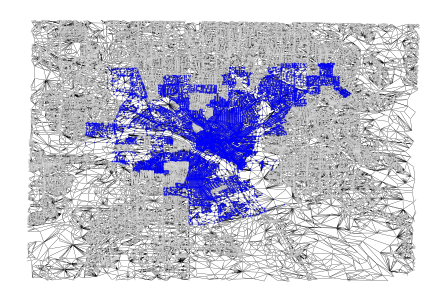

In [295]:
col_map = {v:0 if v in greedy_plan else 1 for v in G.nodes()}
nx.draw(G, pos = {x: pos_map[x] for x in G.nodes()}, node_size = 0.1, width = 0.25,
        node_color=[col_map[v] for v in G.nodes()],
        cmap = matplotlib.colors.ListedColormap(rand_colors))

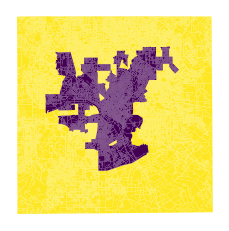

In [301]:
p = Partition(G, col_map, updaters={"cut_edges": cut_edges, "population": Tally("TOTPOP10")})
p.plot()
plt.axis('off')
plt.savefig("test.png")

In [298]:
success

True

In [297]:
p["population"]

{1: 1773102, 0: 595037}

In [287]:
(1-ep)*(2368139 / 4), (1+ep)*(2368139 / 4)

(562433.0125, 621636.4875)

In [299]:
(1-0.02)*(2368139 / 4), (1+0.02)*(2368139 / 4)

(580194.0549999999, 603875.4450000001)

In [204]:
593935

593935

In [166]:
%%time
H = foldr(lambda n, h: nx.contracted_nodes(h, nodes[0], n, self_loops=False), G, nodes[1:])

CPU times: user 2min 28s, sys: 2.53 s, total: 2min 31s
Wall time: 2min 31s


In [167]:
H

<Graph [43982 nodes, 106212 edges]>

In [176]:
%%time
foldr(lambda n, st: st | set(nx.neighbors(G, n)), set(), nodes) - set(nodes)

CPU times: user 560 µs, sys: 1 µs, total: 561 µs
Wall time: 565 µs


{77,
 1401,
 2073,
 2574,
 2932,
 5193,
 5202,
 5205,
 5206,
 5212,
 6168,
 6467,
 7546,
 7752,
 7900,
 9654,
 10944,
 11086,
 11089,
 11270,
 12200,
 12201,
 12206,
 13485,
 15101,
 21627,
 22592,
 25218,
 25328,
 25335,
 25819,
 26476,
 28142,
 28180,
 28822,
 29483,
 30645,
 30646,
 31201,
 31230,
 33041,
 33042,
 33641,
 34125,
 34450,
 34582,
 38070,
 38618,
 39553,
 39684,
 39705,
 39711,
 39743,
 40379,
 40724,
 40942}

In [175]:
sorted(list(nx.neighbors(H, 78)))

[77,
 1401,
 2073,
 2574,
 2932,
 5193,
 5202,
 5205,
 5206,
 5212,
 6168,
 6467,
 7546,
 7752,
 7900,
 9654,
 10944,
 11086,
 11089,
 11270,
 12200,
 12201,
 12206,
 13485,
 15101,
 21627,
 22592,
 25218,
 25328,
 25335,
 25819,
 26476,
 28142,
 28180,
 28822,
 29483,
 30645,
 30646,
 31201,
 31230,
 33041,
 33042,
 33641,
 34125,
 34450,
 34582,
 38070,
 38618,
 39553,
 39684,
 39705,
 39711,
 39743,
 40379,
 40724,
 40942]

In [156]:
 nodes#[1:]

[78,
 2686,
 2687,
 5192,
 5317,
 6277,
 6286,
 6466,
 6470,
 6499,
 7547,
 7751,
 7753,
 7754,
 7755,
 7901,
 9026,
 9458,
 10000,
 10002,
 10022,
 10023,
 10024,
 10138,
 10951,
 11085,
 11087,
 11088,
 11271,
 11409,
 12007,
 12008,
 12528,
 12539,
 12541,
 12542,
 13486,
 13487,
 13488,
 13969,
 15092,
 15093,
 15098,
 15099,
 15100,
 15130,
 16065,
 16070,
 16947,
 17501,
 19201,
 19202,
 21624,
 21625,
 21626,
 21628,
 21629,
 21630,
 22241,
 23114,
 23881,
 23882,
 24158,
 24159,
 24160,
 24391,
 24392,
 25217,
 25336,
 25460,
 25461,
 26477,
 26510,
 26966,
 28140,
 28141,
 28705,
 28829,
 28831,
 29345,
 29482,
 29484,
 29485,
 29688,
 29689,
 29891,
 30643,
 30644,
 30880,
 31199,
 31200,
 31203,
 31204,
 31727,
 31729,
 32068,
 32209,
 32705,
 32706,
 34124,
 34446,
 34447,
 34448,
 34449,
 34451,
 34583,
 35400,
 35992,
 37267,
 38661,
 38664,
 38665,
 38912,
 39549,
 39551,
 39552,
 39554,
 39678,
 39685,
 39686,
 39689,
 39690,
 39691,
 39692,
 39693,
 39704,
 39706,
 397

In [145]:
H = nx.contracted_nodes(G, nodes[0], nodes[1], self_loops=False)

In [147]:
G

<Graph [44113 nodes, 106512 edges]>

In [150]:
2686 in H.nodes

False

In [101]:
G.nodes[0]["GEOID10"][:-4]

'48113012400'

In [121]:
from collections import defaultdict 
tract_dict = {v: G.nodes[v]['GEOID10'][:-4] for v in G.nodes()}
bg_dict = {v: G.nodes[v]['GEOID10'][:-3] for v in G.nodes()}

tract_map = defaultdict(list) 
for key, val in sorted(tract_dict.items()): 
    tract_map[val].append(key)
    
bg_map = defaultdict(list) 
for key, val in sorted(bg_dict.items()): 
    bg_map[val].append(key)

In [122]:
tract_map

defaultdict(list,
            {'48113012400': [0,
              2309,
              5257,
              5262,
              5263,
              6212,
              6511,
              7138,
              7139,
              7816,
              12282,
              12284,
              12285,
              12286,
              12604,
              12606,
              12607,
              12608,
              12609,
              13534,
              13535,
              13536,
              13537,
              13538,
              13539,
              14371,
              15596,
              20441,
              22133,
              22134,
              22135,
              22162,
              22164,
              22167,
              22794,
              24469,
              27030,
              27464,
              27465,
              27709,
              28552,
              28553,
              30370,
              30371,
              30433,
              30434,
              

In [123]:
bg_map

defaultdict(list,
            {'481130124005': [0,
              6212,
              7138,
              14371,
              22133,
              22134,
              22135,
              27465,
              28553,
              30371,
              30434,
              31348,
              31801,
              38343,
              43347],
             '481130182062': [1,
              613,
              1429,
              3604,
              3701,
              18833,
              20721,
              20722,
              22137,
              23678,
              24577,
              27031,
              27032,
              28555,
              28680,
              29531,
              38344,
              38345,
              38346,
              38348,
              42433,
              42804,
              42805,
              42806,
              42831,
              43349],
             '481130182061': [2,
              1704,
              6215,
              7140,
         

In [211]:
ls = []
ls.extend([1,2])

In [212]:
ls

[1, 2]